In [3]:
from enum import Enum
import math
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'

def oneStepBinomial(S:float, r:float, u:float, d:float, optType:PayoffType, K:float, T:float) -> float:
    p = (math.exp(r*T) - d) / (u - d)
    if optType == PayoffType.Call:
        return math.exp(-r*T) * (p * max(S*u-K, 0) + (1 - p) * max(S*d-K, 0))

In [4]:
oneStepBinomial(S = 100, r = 0.01, u = 1.2, d = 0.8, optType = PayoffType.Call, K = 105, T = 1)

7.798504987524955

In [22]:
def cnorm(x):
    return (1 + math.erf(x / math.sqrt(2)))/2

def bsPrice(S, r, vol, T, strike, payoffType):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    elif payoffType == PayoffType.BinaryCall:
        return math.exp(-r * T) * cnorm(d1)
    elif payoffType == PayoffType.BinaryPut:
        return math.exp(-r * T) * (1-cnorm(-d1))
    else:
        raise Exception("not supported payoff type", payoffType)

In [16]:
S, r, vol, K, T, u, d = 100, 0.01, 0.2, 105, 1.0, 1.2, 0.8
print('blackPrice: ', bsPrice(S, r, vol, PayoffType.Call, K, T))
print('oneStepTree: ', oneStepBinomial(S, r, u, d, PayoffType.Call, K, T))

blackPrice:  6.297254539086019
oneStepTree:  7.798504987524955


In [17]:
def oneStepBinomial2(S, r, vol, optType, K, T):
    b = math.exp(vol * vol * T+r*T) + math.exp(-r * T)
    u = (b + math.sqrt(b*b - 4)) / 2
    d = 1/u
    p = (math.exp(r * T) - d) / (u-d)
    if optType == PayoffType.Call:
        return math.exp(-r * T) * (p * max(S * u - K, 0) + (1-p) * max(S * d - K, 0))

In [19]:
# test ---
S,r,vol,K,T,u,d = 100, 0.01, 0.2, 105, 1.0, 1.2, 0.8
print("blackPrice: ", bsPrice(S, r, vol, PayoffType.Call, K, T))
print("oneStepTree1: \t", oneStepBinomial(S, r, u, d, PayoffType.Call, K, T))
print("oneStepTree2: \t", oneStepBinomial2(S, r, vol, PayoffType.Call, K, T))

blackPrice:  6.297254539086019
oneStepTree1: 	 7.798504987524955
oneStepTree2: 	 8.212289615248919


In [20]:
def crrBinomial(S, r, vol, payoffType, K, T, n):
    t = T / n
    b = math.exp(vol * vol * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    # set up the last time slice, there are n+1 nodes at the last time slice
    payoffDict = {
        PayoffType.Call: lambda s: max(s-K, 0),
        PayoffType.Put: lambda s: max(K-s, 0),
    }
    vs = [payoffDict[payoffType]( S * u**(n-i-i)) for i in range(n+1)]
    # iterate backward
    for i in range(n-1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            vs[j] = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
    return vs[0]

In [23]:
# test ---
S, r, vol, K, T = 100, 0.01, 0.2, 105, 1.0
print("blackPrice: \t", bsPrice(S, r, vol, T, K, PayoffType.Call))
print("crrNStepTree: \t", crrBinomial(S, r, vol, PayoffType.Call, K, T, 300))

blackPrice: 	 6.297254539086019
crrNStepTree: 	 6.296057152109465


In [24]:
import matplotlib.pyplot as plt
n = 300
S, r, vol, K, T = 100, 0.01, 0.2, 105, 1.0
bsPrc = bsPrice(S, r, vol, T, K, PayoffType.Call)
crrErrs = [(crrBinomial(S,r,vol,PayoffType.Call,K,T,i) - bsPrc) for i in range(1, n)]

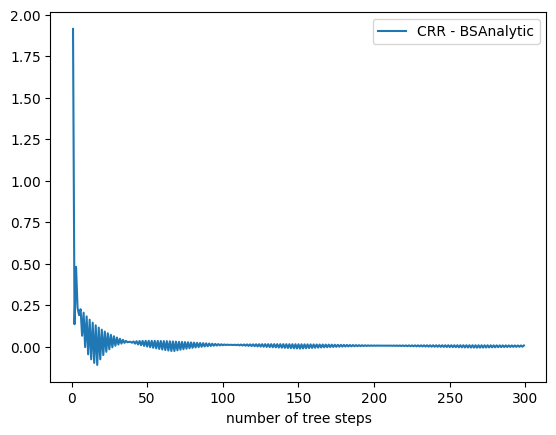

In [25]:
plt.plot(range(1, n), crrErrs, label = "CRR - BSAnalytic")
plt.xlabel('number of tree steps')
plt.legend()
# plt.yscale('log')
plt.show()

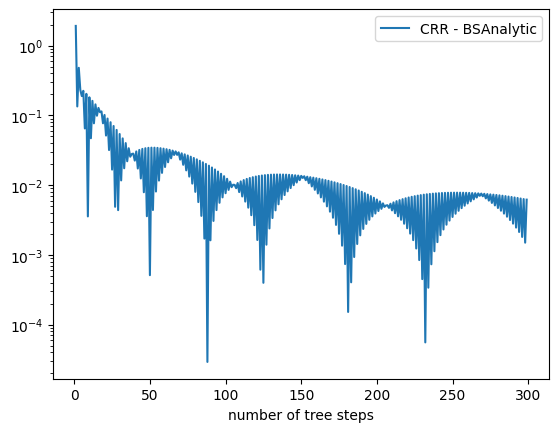

In [31]:
import matplotlib.pyplot as plt
n = 300
S, r, vol, K, T = 100, 0.01, 0.2, 105, 1.0
bsPrc = bsPrice(S, r, vol, T, K, PayoffType.Call)
crrErrs = [abs(crrBinomial(S,r,vol,PayoffType.Call,K,T,i) - bsPrc) for i in range(1, n)] # abs error here
plt.plot(range(1, n), crrErrs, label = "CRR - BSAnalytic")
plt.xlabel('number of tree steps')
plt.yscale('log') # plot on log scale
plt.legend()

In [32]:
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        elif self.payoffType == PayoffType.BinaryCall:
            if S > self.strike:
                return 1.0
            else:
                return 0.0
        elif self.payoffType == PayoffType.BinaryPut:
            if S < self.strike:
                return 1.0
            else:
                return 0.0
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

In [33]:
class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)